In [1]:
import sys, os, json, copy, sklearn, shap, gc, joblib, copy, time, ast
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from rdsutils.woe import WOE_Transform                                            
from rdsutils.metrics import get_pred_reports


sys.path.insert(1, "./")
from utility.performance_eval_plot import score_gain, plot_efficient_frontier, plot_percentile_bad_rate
import utility.performance_eval_v3 as p_eval
from utility  import data_summary, woe, data_eda, psi
from utility.governance import get_risk_plot,get_feature_by_importance, get_pdp, get_shap_dependence, pickle_obj, save_shap_dependence,\
    save_pdp, plot_hist, get_woe_plots

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

print(lgb.__version__)

3.2.1


### read data

In [2]:
config_path = "s3://sofi-data-science/hpeng/pl-gen4/artifact/config.json"
artifact_path = "s3://sofi-data-science/hpeng/pl-gen4/artifact"
with open(os.path.join(config_path), "r") as f:
    config = json.load(f)

In [3]:
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])
af_dict = pd.read_csv(config["meta"]["af_member_cust_dict_path"])

In [4]:
model_member = pkl.load(open('artifact/'+'member'+'_final_model.pkl', 'rb'))
model_non_member = pkl.load(open('artifact/'+'non_member'+'_final_model.pkl', 'rb'))
model_non_member29 = pkl.load(open('artifact/'+'non_member'+'_final_model_29.pkl', 'rb'))
model_non_member30 = pkl.load(open('artifact/'+'non_member'+'_final_model_30.pkl', 'rb'))
model_prescreen = pkl.load(open('artifact/'+'prescreen'+'_final_model.pkl', 'rb'))

Trying to unpickle estimator LabelEncoder from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [5]:
feature_list = model_prescreen.feature_name_ + model_member.feature_name_ + model_non_member.feature_name_ \
            + model_non_member30.feature_name_ + config["data_columns"]["weights"] \
            + config["data_columns"]["target_cols"] + config["data_columns"]["benchmark_cols"] + \
            config["data_columns"]["meta_cols"] + ['all_time_lending_member_flag'] + ['funds_use_encode_v2','income_update']
feature_list = pd.unique(feature_list).tolist()

In [6]:
df_oot1_full = pd.read_parquet(config["data"]["clean"]["all_features_dev1"], columns = feature_list)
df_oot2_full = pd.read_parquet(config["data"]["clean"]["all_features_dev2"], columns = feature_list)
df_oot_full = pd.concat([df_oot1_full, df_oot2_full], axis=0, ignore_index=True)

df_oot_full['seg'] = 'other'
df_oot_full.loc[(df_oot_full.all_time_lending_member_flag==1), 'seg'] = 'member'
df_oot_full.loc[(df_oot_full.all_time_lending_member_flag!=1), 'seg'] = 'non_member'

### data preprecessing

In [7]:
def categorical_to_nan(series, categorical_list):
    """ given series and a list of catergorical values
    
    replace the categorical occurances to nan
    """
    if len(categorical_list) == 0:
        return series
    mapper = dict((k, np.nan) for k in categorical_list)
    return series.replace(mapper)

no_special_list = []

for col in tqdm(feature_list):
    try:
        special_val = ast.literal_eval(exp_dict[exp_dict.field_name == col].categorical.iloc[0])
        special_val = [int(i) for i in special_val]
        df_oot_full[col] = categorical_to_nan(df_oot_full[col], special_val)
    except:
        no_special_list.append(col)
        
len(no_special_list)

100%|██████████| 89/89 [00:12<00:00,  6.86it/s]


30

In [9]:
df_oot_full_member_ = df_oot_full[df_oot_full.seg=='member'].copy()
df_oot_full_non_member_ = df_oot_full[df_oot_full.seg=='non_member'].copy()
df_oot_full_prescreen_ = df_oot_full.copy()
df_oot_full_non_member_30_ = df_oot_full[df_oot_full.seg=='non_member'].copy()


impute_vals_member = pkl.load(open('artifact/'+'member'+'_final_imputed_val.pkl', 'rb'))
impute_vals_non_member = pkl.load(open('artifact/'+'non_member'+'_final_imputed_val.pkl', 'rb'))
impute_vals_prescreen = pkl.load(open('artifact/'+'prescreen'+'_final_imputed_val.pkl', 'rb'))
impute_vals_non_member_30 = pkl.load(open('artifact/'+'non_member'+'_final_imputed_val_30.pkl', 'rb'))


for f in tqdm(model_member.feature_name_):
    try:
        val = impute_vals_member[f]
        df_oot_full_member_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)    
        
for f in tqdm(model_non_member.feature_name_):
    try:
        val = impute_vals_non_member[f]
        df_oot_full_non_member_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)
        
for f in tqdm(model_prescreen.feature_name_):
    try:
        val = impute_vals_prescreen[f]
        df_oot_full_prescreen_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)
        
for f in tqdm(model_non_member30.feature_name_):
    try:
        val = impute_vals_non_member_30[f]
        df_oot_full_non_member_30_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)

100%|██████████| 31/31 [00:00<00:00, 1027.86it/s]


no special value for p13_iqz9420
no special value for p13_iqz9426
no special value for sofi_num_inq_12month


 35%|███▌      | 11/31 [00:00<00:00, 97.57it/s]

no special value for p13_iqz9427


100%|██████████| 31/31 [00:00<00:00, 98.16it/s] 


no special value for sofi_num_inq_1month
no special value for sofi_num_inq_3month
no special value for sofi_num_inq_personal_finance


  0%|          | 0/31 [00:00<?, ?it/s]

no special value for p13_iqz9420


 65%|██████▍   | 20/31 [00:00<00:00, 83.41it/s]

no special value for p13_iqz9425


100%|██████████| 30/30 [00:00<00:00, 101.73it/s]

no special value for p13_iqz9427
no special value for sofi_num_inq_1month
no special value for sofi_num_inq_3month
no special value for sofi_num_inq_personal_finance


In [10]:
# df_oot_full_member_[~((df_oot_full_member_.ri_source == 'others') & (df_oot_full_member_.target_v2 == 0))].to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_member_psi_dev.parquet')
# df_oot_full_non_member_[~((df_oot_full_non_member_.ri_source == 'others') & (df_oot_full_non_member_.target_v2 == 0))].to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_nonmember_psi_dev.parquet')
# df_oot_full_prescreen_[~((df_oot_full_prescreen_.ri_source == 'others') & (df_oot_full_prescreen_.target_v2 == 0))].to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_prescreen_psi_dev.parquet')

### scoring

In [11]:
df_oot_full_member_['gen4_underwriting_prob'] = model_member.predict_proba(df_oot_full_member_[model_member.feature_name_])[:,1]
df_oot_full_non_member_['gen4_underwriting_prob'] = model_non_member.predict_proba(df_oot_full_non_member_[model_non_member.feature_name_])[:,1]

df_oot_full_member_['gen4_underwriting_prob_29'] = model_member.predict_proba(df_oot_full_member_[model_member.feature_name_])[:,1]
df_oot_full_non_member_['gen4_underwriting_prob_29'] = model_non_member29.predict_proba(df_oot_full_non_member_[model_non_member29.feature_name_])[:,1]

df_oot_full_member_['gen4_underwriting_prob_30'] = model_member.predict_proba(df_oot_full_member_[model_member.feature_name_])[:,1]
df_oot_full_non_member_30_['gen4_underwriting_prob_30'] = model_non_member30.predict_proba(df_oot_full_non_member_30_[model_non_member30.feature_name_])[:,1]

df_oot_ = pd.concat([df_oot_full_member_, df_oot_full_non_member_], axis=0, ignore_index=True)
df_oot_["weight_eval"] = df_oot_["weight_cob"] * df_oot_["weight_ri_v2"]

df_oot_30_ = pd.concat([df_oot_full_member_, df_oot_full_non_member_30_], axis=0, ignore_index=True)
df_oot_30_["weight_eval"] = df_oot_30_["weight_cob"] * df_oot_30_["weight_ri_v2"]

df_oot_full_prescreen_['gen4_prescreen_prob'] = model_prescreen.predict_proba(df_oot_full_prescreen_[model_prescreen.feature_name_])[:,1]
df_oot_full_prescreen_["weight_eval"] = df_oot_full_prescreen_["weight_cob"] * df_oot_full_prescreen_["weight_ri_v2"]

In [12]:
df_oot_.shape, df_oot_full_prescreen_.shape, df_oot_30_.shape

((4404764, 94), (4404764, 92), (4404764, 94))

In [13]:
df_oot_ = pd.merge(df_oot_[['id','applicant_type','date_start','seg','ri_source','target_v2','weight_eval',\
             'period',  'gen3_score','applicant_fico_score','applicant_vantage_score','funds_use_encode_v2','income_update',\
                            'gen4_underwriting_prob','gen4_underwriting_prob_29']], df_oot_full_prescreen_[['gen4_prescreen_prob','id','applicant_type','date_start','weight_eval']],
              how = 'inner', on = ['id', 'applicant_type', 'date_start','weight_eval'])
df_oot_ = pd.merge(df_oot_, df_oot_30_[['gen4_underwriting_prob_30','id','applicant_type','date_start','weight_eval']],
              how = 'inner', on = ['id', 'applicant_type', 'date_start','weight_eval'])

In [14]:
df_oot_.shape

(4404764, 17)

### probability to score transformation
- range 300~850
- 40 double odds
- odds 5:1 at score 650

In [15]:
factor = 40/np.log(2)
offset = 650 - factor * np.log(5)

df_oot_['uw_log_odds'] = np.log((1 - df_oot_['gen4_underwriting_prob'])/df_oot_['gen4_underwriting_prob'])
df_oot_['uw_odds'] = ((1 - df_oot_['gen4_underwriting_prob'])/df_oot_['gen4_underwriting_prob'])

df_oot_['gen4_underwriting_score'] = round(offset+factor*df_oot_['uw_log_odds'])
df_oot_.loc[df_oot_.gen4_underwriting_score>850,'gen4_underwriting_score']=850
df_oot_.loc[df_oot_.gen4_underwriting_score<300,'gen4_underwriting_score']=300

df_oot_['uw_log_odds_29'] = np.log((1 - df_oot_['gen4_underwriting_prob_29'])/df_oot_['gen4_underwriting_prob_29'])
df_oot_['uw_odds_29'] = ((1 - df_oot_['gen4_underwriting_prob_29'])/df_oot_['gen4_underwriting_prob_29'])

df_oot_['gen4_underwriting_score_29'] = round(offset+factor*df_oot_['uw_log_odds_29'])
df_oot_.loc[df_oot_.gen4_underwriting_score_29>850,'gen4_underwriting_score_29']=850
df_oot_.loc[df_oot_.gen4_underwriting_score_29<300,'gen4_underwriting_score_29']=300

df_oot_['uw_log_odds_30'] = np.log((1 - df_oot_['gen4_underwriting_prob_30'])/df_oot_['gen4_underwriting_prob_30'])
df_oot_['uw_odds_30'] = ((1 - df_oot_['gen4_underwriting_prob_30'])/df_oot_['gen4_underwriting_prob_30'])

df_oot_['gen4_underwriting_score_30'] = round(offset+factor*df_oot_['uw_log_odds_30'])
df_oot_.loc[df_oot_.gen4_underwriting_score_30>850,'gen4_underwriting_score_30']=850
df_oot_.loc[df_oot_.gen4_underwriting_score_30<300,'gen4_underwriting_score_30']=300

df_oot_['pr_log_odds'] = np.log((1 - df_oot_['gen4_prescreen_prob'])/df_oot_['gen4_prescreen_prob'])
df_oot_['pr_odds'] = ((1 - df_oot_['gen4_prescreen_prob'])/df_oot_['gen4_prescreen_prob'])

df_oot_['gen4_prescreen_score'] = round(offset+factor*df_oot_['pr_log_odds'])
df_oot_.loc[df_oot_.gen4_prescreen_score>850,'gen4_prescreen_score']=850
df_oot_.loc[df_oot_.gen4_prescreen_score<300,'gen4_prescreen_score']=300

### save data for performance evaluation

In [16]:
df_oot_['fico_adj'] = np.where(df_oot_.applicant_fico_score>850, 300, df_oot_.applicant_fico_score)
keep_list = ['id','applicant_type','date_start','seg','ri_source','target_v2','weight_eval','gen4_prescreen_score','gen4_prescreen_prob',
             'period', 'gen4_underwriting_prob', 'gen4_underwriting_score', 'gen4_underwriting_prob_29', 'gen4_underwriting_score_29',
             'gen4_underwriting_prob_30', 'gen4_underwriting_score_30','gen3_score','fico_adj',
             'applicant_vantage_score','funds_use_encode_v2','income_update']

In [17]:
artifact_path+ "/" + 'df_gen4_score_dev.parquet'

's3://sofi-data-science/hpeng/pl-gen4/artifact/df_gen4_score_dev.parquet'

In [18]:
df_oot_[keep_list].to_parquet(artifact_path+ "/" + 'df_gen4_score_dev_refit.parquet')
df_oot_[keep_list].to_parquet('./artifact/df_gen4_score_dev_refit.parquet')

In [28]:
# prepare fair lending data
keep_list = ['id','applicant_type','date_start','seg','ri_source','target_v2','gen4_prescreen_score',
            'gen4_underwriting_score','gen4_underwriting_score_29','gen4_underwriting_score_30']
df_oot_[(df_oot_.ri_source!='others') | (df_oot_['target_v2']==0)][keep_list].to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/cleaned_tables/uw/df_fl_v3.parquet')

### distribution

In [19]:
df = df_oot_.copy()

Text(0.5, 1.0, 'Score Distribution')

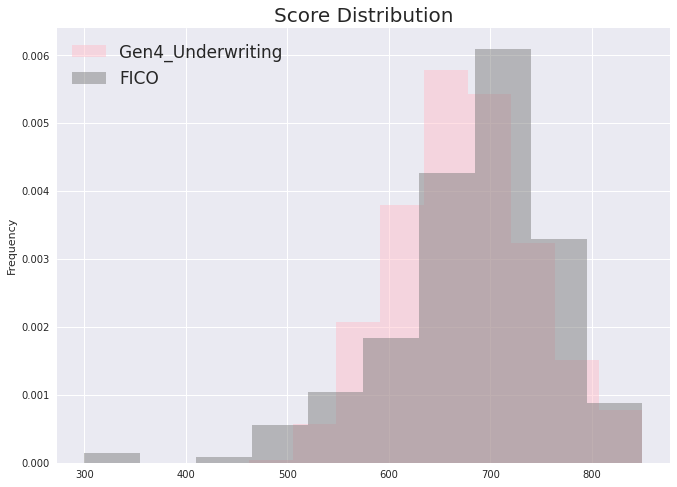

In [24]:
plt.figure(figsize=(11,8))
df[(df.ri_source!='others') | (df['target_v2']==0)]['gen4_underwriting_score'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df[(df.ri_source!='others') | (df['target_v2']==0)]['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

Text(0.5, 1.0, 'Score Distribution')

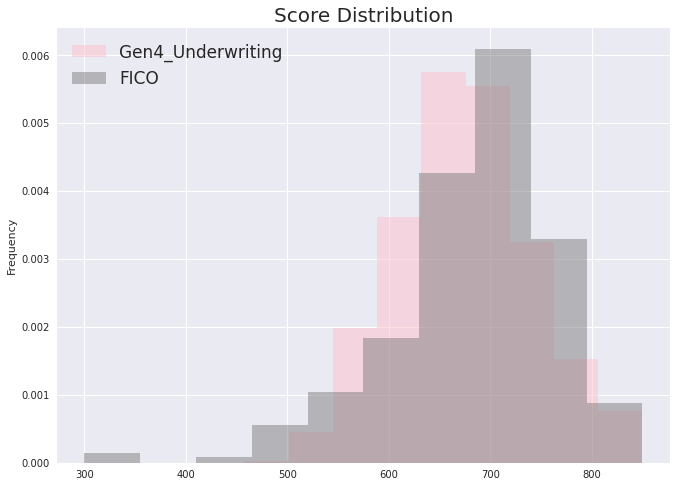

In [25]:
plt.figure(figsize=(11,8))
df[(df.ri_source!='others') | (df['target_v2']==0)]['gen4_underwriting_score_29'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df[(df.ri_source!='others') | (df['target_v2']==0)]['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

Text(0.5, 1.0, 'Score Distribution')

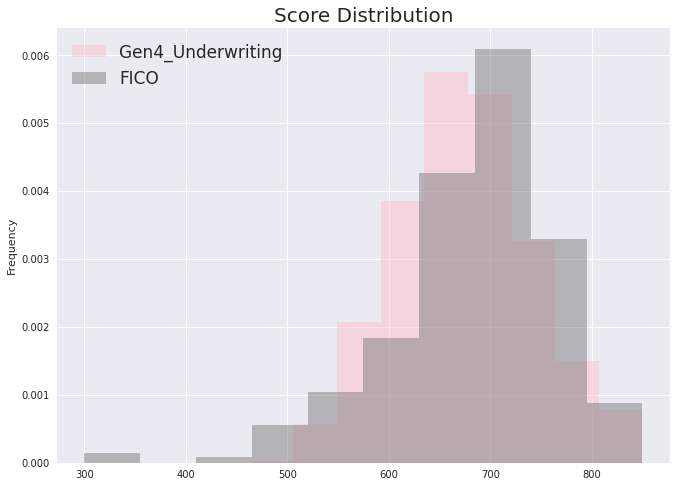

In [26]:
plt.figure(figsize=(11,8))
df[(df.ri_source!='others') | (df['target_v2']==0)]['gen4_underwriting_score_30'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df[(df.ri_source!='others') | (df['target_v2']==0)]['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

Text(0.5, 1.0, 'Score Distribution')

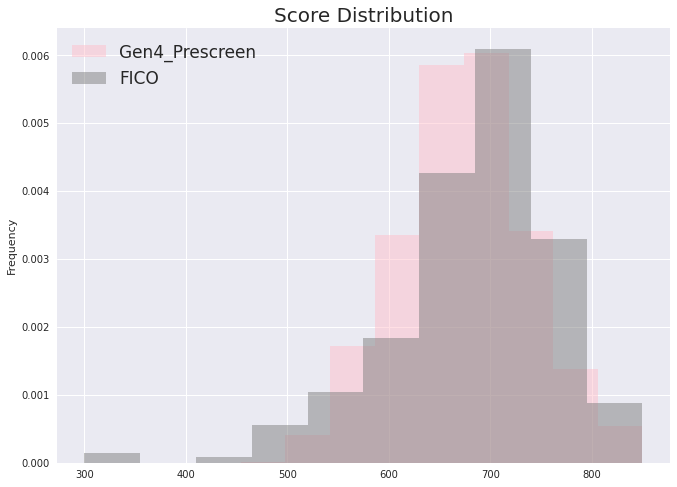

In [27]:
plt.figure(figsize=(11,8))
df[(df.ri_source!='others') | (df['target_v2']==0)]['gen4_prescreen_score'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Prescreen',color='pink')
df[(df.ri_source!='others') | (df['target_v2']==0)]['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

### actual v.s. predicted odds

In [29]:
df['ca_odds'] = ((1 - df['gen4_underwriting_prob_29'])/df['gen4_underwriting_prob_29'])
df['pr_odds'] = ((1 - df['gen4_prescreen_prob'])/df['gen4_prescreen_prob'])

cutoff=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,20,25,30,40,50,70,100,10000]
df['ca_odds_bin']=pd.cut(df['ca_odds'],cutoff,right=True)
df['pr_odds_bin']=pd.cut(df['pr_odds'],cutoff,right=True)

In [30]:
ds_m = data_summary.DataSummary(df[df.seg=='member'],['gen4_underwriting_prob_29','target_v2'],segment=['ca_odds_bin'],weight='weight_eval')
table1 = ds_m.get_report()

In [31]:
ds_nm = data_summary.DataSummary(df[df.seg!='member'],['gen4_underwriting_prob_29','target_v2'],segment=['ca_odds_bin'],weight='weight_eval')
table2 = ds_nm.get_report()

In [32]:
combo=table1.merge(table2,how='inner',on='ca_odds_bin')
combo

,ca_odds_bin,total cnt_x,gen4_underwriting_prob_29_x,target_v2_x,total cnt_y,gen4_underwriting_prob_29_y,target_v2_y
0,"(0, 1]",791.0,0.565966,0.487908,101123.0,0.572675,0.516583
1,"(1, 2]",4900.5,0.394624,0.359823,220824.5,0.408103,0.401148
2,"(2, 3]",7776.5,0.286027,0.275439,201760.5,0.288415,0.295995
3,"(3, 4]",8575.0,0.222762,0.220972,179744.0,0.223595,0.233278
4,"(4, 5]",8728.5,0.182297,0.185890,161844.0,0.182625,0.193157
5,"(5, 6]",8343.0,0.154402,0.158477,143688.5,0.154428,0.163170
6,"(6, 7]",7939.0,0.133753,0.140508,125709.5,0.133706,0.139319
7,"(7, 8]",7482.5,0.117942,0.126241,108628.0,0.117962,0.121917
8,"(8, 9]",6838.0,0.105428,0.107415,94961.5,0.105498,0.107911
9,"(9, 10]",6220.5,0.095444,0.100857,82382.5,0.095412,0.097203


In [33]:
ds_nm = data_summary.DataSummary(df[df.seg!='member'],['gen4_prescreen_prob','target_v2'],segment=['pr_odds_bin'],weight='weight_eval')
table3 = ds_nm.get_report()

In [34]:
table3

,pr_odds_bin,total cnt,gen4_prescreen_prob,target_v2
0,"(0, 1]",107063.0,0.571458,0.511506
1,"(1, 2]",200117.5,0.407270,0.398552
2,"(2, 3]",192799.5,0.288116,0.296103
3,"(3, 4]",177263.5,0.223432,0.235875
4,"(4, 5]",163155.0,0.182608,0.197253
5,"(5, 6]",148064.5,0.154359,0.167296
6,"(6, 7]",131448.0,0.133706,0.144393
7,"(7, 8]",114950.0,0.117954,0.126860
8,"(8, 9]",100378.0,0.105496,0.111906
9,"(9, 10]",87201.0,0.095425,0.101955


### gains table

gen4_prescreen_prob AUC:  0.76087  KS:  38.6

Gains Table--Model:
   pct_cum_acct    #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.4%  109000.5  0.4983  0.9280     55682.8          13.8%              2.6%       51.1%  11.2
1          9.0%  110321.0  0.3919  0.4983     47146.0          25.5%              5.7%       42.7%  19.8
2         13.5%  112265.0  0.3214  0.3919     39954.4          35.4%              9.2%       35.6%  26.2
3         18.2%  114402.0  0.2714  0.3214     34544.4          44.0%             13.1%       30.2%  30.9
4         22.9%  115994.0  0.2332  0.2714     30445.8          51.5%             17.3%       26.2%  34.2
5         27.8%  118109.0  0.2031  0.2332     27164.2          58.3%             21.8%       23.0%  36.5
6         32.6%  119447.0  0.1786  0.2031     24435.0          64.3%             26.4%       20.5%  37.9
7         37.6%  121101.0  0.1582  0.1786     21930.1          69.8%             31.2%       1

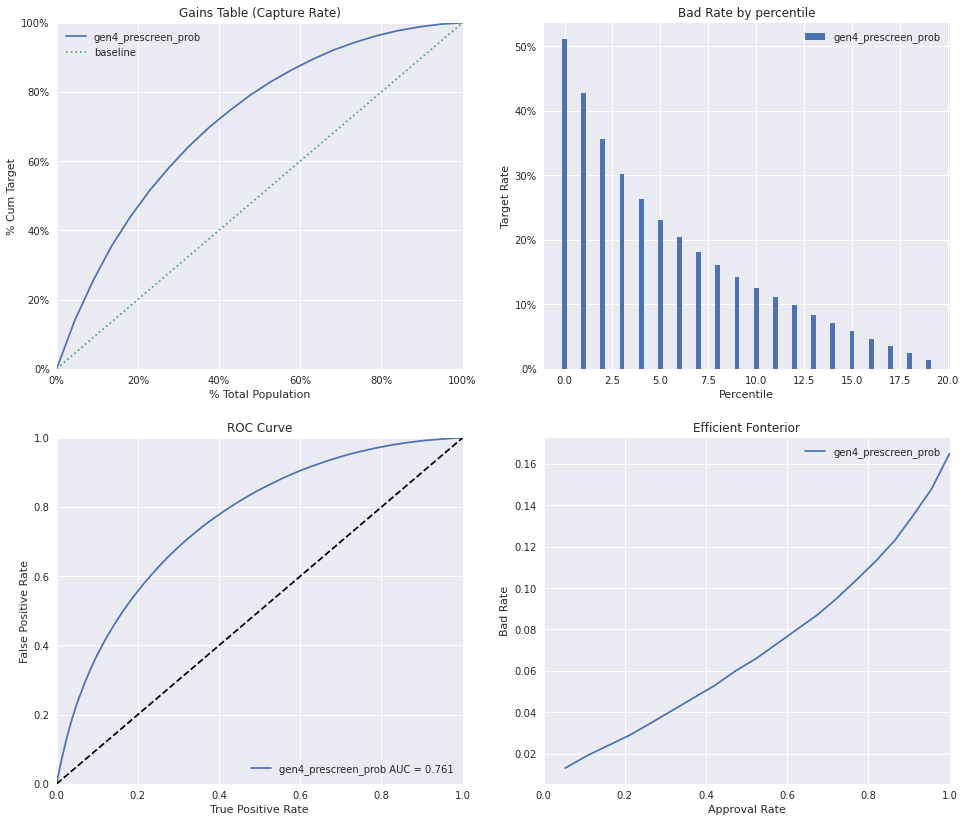

(0.7608705526180887, 38.599999999999994)

In [26]:
p_eval.model_score_eval(df['target_v2'],
                        df['gen4_prescreen_prob'],
                        Y_weight=df['weight_eval'],decile=20)

gen4_underwriting_prob_29 AUC:  0.76806  KS:  39.8

Gains Table--Model:
   pct_cum_acct    #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.5%  109036.5  0.4936  0.9233     56008.4          13.9%              2.6%       51.4%  11.3
1          9.0%  110206.5  0.3992  0.4936     47476.8          25.7%              5.7%       43.1%  20.0
2         13.5%  112223.0  0.3314  0.3992     40756.2          35.8%              9.1%       36.3%  26.7
3         18.2%  113902.0  0.2817  0.3314     35581.0          44.6%             13.0%       31.2%  31.6
4         22.9%  115715.0  0.2427  0.2817     31075.1          52.3%             17.1%       26.9%  35.2
5         27.7%  116991.0  0.2110  0.2427     27571.9          59.1%             21.5%       23.6%  37.6
6         32.5%  118320.0  0.1850  0.2110     24440.0          65.2%             26.1%       20.7%  39.1
7         37.4%  120010.0  0.1632  0.1850     22168.8          70.7%             30.9%  

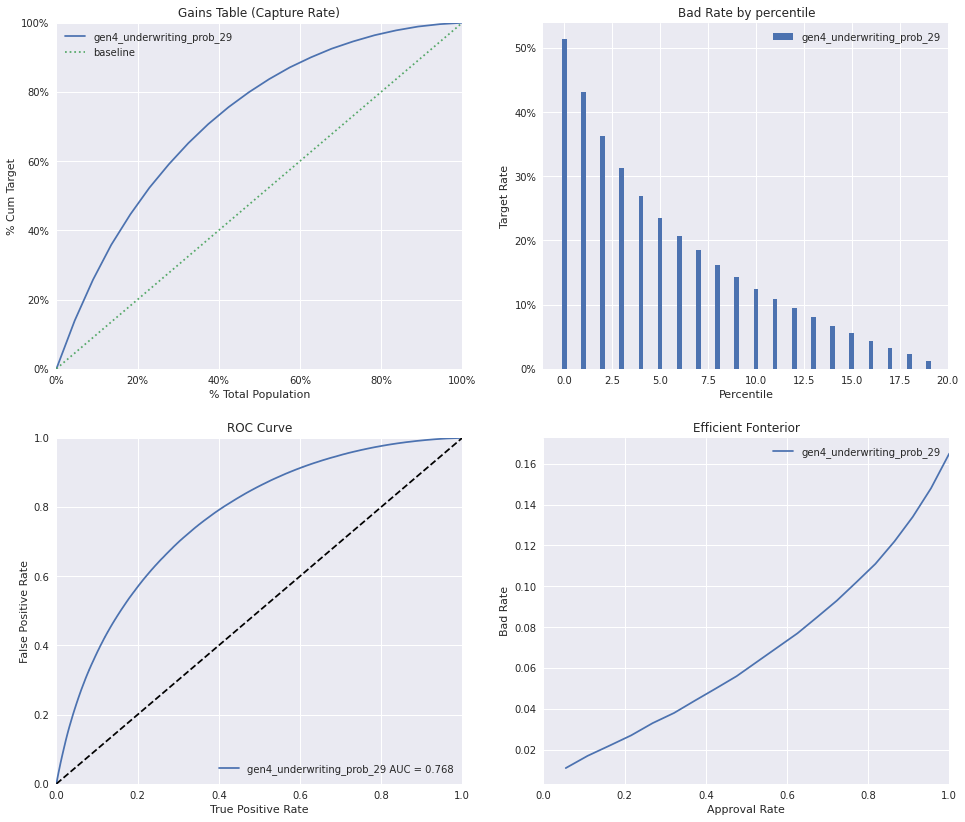

(0.7680607248020046, 39.800000000000004)

In [35]:
p_eval.model_score_eval(df['target_v2'],
                        df['gen4_underwriting_prob_29'],
                        Y_weight=df['weight_eval'],decile=20)